# 0. 참고자료
## 0-1. 도서
## 0-2. 웹사이트
- 길이가 다른 sequence를 multiple sequence alignment | stackoverflow [[페이지 링크]](https://stackoverflow.com/questions/31152011/multiple-sequence-alignment-with-unequal-string-length)
- 인코덤 | Biopython/PhyIo [[페이지 링크]](http://www.incodom.kr/Biopython/Phylo)
- 유럽 생물정보학 연구소 | phylogeny input example [[페이지 링크]](https://www.ebi.ac.uk/seqdb/confluence/display/JDSAT/Phylogeny+Input+Examples)
## 0-3. 데이터셋
- 인간 DNA 데이터 | Kaggle(by Neel Vasani) human-dna-data [[데이터 셋 링크]](https://www.kaggle.com/datasets/neelvasani/humandnadata)  
- 강아지, 침팬지 데이터 | Kaggle(by Neel Vasani) chimpanzee and dog dna [[데이터 셋 링크]](https://www.kaggle.com/datasets/neelvasani/chimpanzee-and-dog-dna)


In [6]:
from Bio.Align.Applications import MuscleCommandline
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import GC
from Bio.Seq import Seq
from Bio import SeqIO
import re, os

In [14]:
## Kaggle에서 제공된 데이터 셋이 txt 파일로 되어 있어
## SeqIO가 아닌 파이썬의 파일 입출력으로 염기서열을 가져옴.
def text_parsing(spieces):
    sequence_txt = open(f'../dataset/txt/{spieces}_data.txt', 'r').readlines()
    pattern = re.compile('[AGCT]+')
    
    sequences = []
    seq_append = sequences.append
    
    ## text 파일 맨 첫번째 줄에 sequence	class 이런 데이터가 있어 두번째 줄 부터 가져옴.
    for sequence in sequence_txt[1:]:
        ## 두번째 줄부터 문자열 끝부분에 숫자가 붙어있어 정규표현식으로 염기서열(A, G, C, T)만 가져옴.
        match = re.findall(pattern, sequence)
        seq_append(match)
        
    return sequences

## 코드 테스트
print(text_parsing('human')[1][0])
os.makedirs('../dataset/fasta/HCD/', exist_ok = True)
os.makedirs('../dataset/aln/HCD/', exist_ok = True)
os.makedirs('../Weblogo/HCD/', exist_ok = True)
os.makedirs('../dataset/newick/HCD/', exist_ok = True)

ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAGGCCTACCCGCCGCAGTACTGATCATTCTATTTCCCCCTCTATTGATCCCCACCTCCAAATATCTCATCAACAACCGACTAATCACCACCCAACAATGACTAATCAAACTAACCTCAAAACAAATGATAACCATACACAACACTAAAGGACGAACCTGATCTCTTATACTAGTATCCTTAATCATTTTTATTGCCACAACTAACCTCCTCGGACTCCTGCCTCACTCATTTACACCAACCACCCAACTATCTATAAACCTAGCCATGGCCATCCCCTTATGAGCGGGCACAGTGATTATAGGCTTTCGCTCTAAGATTAAAAATGCCCTAGCCCACTTCTTACCACAAGGCACACCTACACCCCTTATCCCCATACTAGTTATTATCGAAACCATCAGCCTACTCATTCAACCAATAGCCCTGGCCGTACGCCTAACCGCTAACATTACTGCAGGCCACCTACTCATGCACCTAATTGGAAGCGCCACCCTAGCAATATCAACCATTAACCTTCCCTCTACACTTATCATCTTCACAATTCTAATTCTACTGACTATCCTAGAAATCGCTGTCGCCTTAATCCAAGCCTACGTTTTCACACTTCTAGTAAGCCTCTACCTGCACGACAACACATAA


In [30]:
def create_seq_record(idx):

    sequences = [
        text_parsing('human')[idx][0],
        text_parsing('dog')[idx][0],
        text_parsing('chimpanzee')[idx][0]
    ]
    
    longest_length = max(len(seq) for seq in sequences)

    ## 가장 긴 염기서열 길이만큼 맞춤.
    ## 가장 긴 염기서열보다 길이가 짧으면 -으로 채움.
    pad_seq = [seq.ljust(longest_length, '-') for seq in sequences]
    names   = ['human', 'dog', 'chimpanzee']
    
    for name, record, ori_record in zip(names, pad_seq, sequences):
        print(f'[{idx}]{name} \n염기 : {record[-15:]} \nGC 함유량 : {GC(record):.3f}')
        print(f'녹는점 : {mt.Tm_Wallace(record):.3f}, \n원본 길이 : {len(ori_record)} (bp), 길이 : {len(record)} (bp)\n')
    
    print('-'*120)
    records = (SeqRecord(Seq(seq), id = name, name = name) for seq, name in zip(pad_seq, names))
    return records

In [17]:
## MUSCLE 실행 해주는 함수
def do_muscle(idx):
    records = create_seq_record(idx)
    
    ## fasta 파일로 저장
    SeqIO.write(records, f'../dataset/fasta/HCD/HCD_{idx}.fasta', format = 'fasta')

    ## MUSCLE로 aln파일 저장
    muscle_path = '../utils/muscle'
    cmd_line = MuscleCommandline(muscle_path, input = f'../dataset/fasta/HCD/HCD_{idx}.fasta', 
                                                 out = f'../dataset/aln/HCD/HCD_{idx}.aln', clw=" ")
    std_out, std_err = cmd_line()

### MUSCLE 실행한 결과
MUSCLE (3.8) multiple sequence alignment


dog             ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAATATTTCTCACCCTC
human           ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTA
chimpanzee      ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCATACTCCTGACACTA
                ***** ** *** ****  **   **    *  *****     * *** * ** ** ** 

dog             TTCATCCTATTTCAACTAAAAATTTCAAATCACTACTACCCAGAAAACCCGATAACCAAA
human           TTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAG
chimpanzee      TTTCTCGTCACCCAACTAAAAATATTAAATTCAAATTACCATCTACCCCCCTCACCAAAA
                **  ** *    *********** * ***     * ****    *   **   * * ** 

dog             TCTGCTAAAATTGCTGGTCAACATAATCCTTGAGAAAACAAATGAACGAAAATCTATTCG
human           CCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCG
chimpanzee      CCCATAAAAATAAAAAACTACAATAAACCCTGAGAACCAAAATGAACGAAAATCTATTCG
                 *    *****        *  * ** ** ******   **************** ****

dog             CTTCTTTCGCTGCCCCCTCAA---TAA
human           CTTCATTCATTGCCCCCACAATCCTAG
chimpanzee      CTTCATTCGCTGCCCCCACAATCCTAG
                **** ***  ******* ***   ** 


In [34]:
## WebLogo 그려보기
from Bio.motifs import Motif
from Bio import AlignIO
from Bio import motifs

def WebLogo(idx):
    sequences = AlignIO.read(f'../dataset/aln/HCD/HCD_{idx}.aln', format = 'clustal')
    proteins, alphabets = [], set()
    protein_append = proteins.append

    for sequence in sequences:
        alphabets = alphabets.union(set(sequence.seq))
        protein_append(sequence.seq)

    alphabets = ''.join(alphabets)
    m = motifs.create(proteins, alphabet = alphabets)
    Motif.weblogo(m, f'../Weblogo/HCD/human_chimpanzee_and_dog_{idx}.png')

In [15]:
## 계통수 표현해 주는 함수
from Bio import Phylo

def phylogenetic_tree(idx):
    tree = Phylo.read(f'../dataset/newick/HCD/h_c_d_{idx}.newick', 'newick')
    print(tree)

    Phylo.draw(tree)

[0]human 
염기 : CCCCCACAATCCTAG 
GC 함유량 : 39.614
녹는점 : 578.000, 
원본 길이 : 207 (bp), 길이 : 207 (bp)

[0]dog 
염기 : CCCCCTCAATAA--- 
GC 함유량 : 34.783
녹는점 : 552.000, 
원본 길이 : 204 (bp), 길이 : 207 (bp)

[0]chimpanzee 
염기 : CCCCCACAATCCTAG 
GC 함유량 : 40.097
녹는점 : 580.000, 
원본 길이 : 207 (bp), 길이 : 207 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=0.265821)
        Clade(branch_length=0.265821)
            Clade(branch_length=0.0462122, name='human')
            Clade(branch_length=0.0462122, name='chimpanzee')
        Clade(branch_length=0.265821, name='dog')


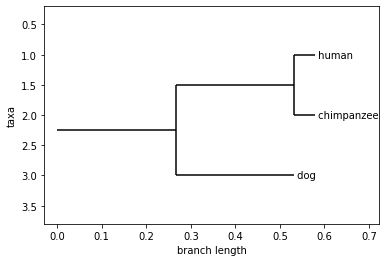

[1]human 
염기 : CACGACAACACATAA 
GC 함유량 : 44.200
녹는점 : 1964.000, 
원본 길이 : 681 (bp), 길이 : 681 (bp)

[1]dog 
염기 : CATGACAACACCTAA 
GC 함유량 : 39.794
녹는점 : 1904.000, 
원본 길이 : 681 (bp), 길이 : 681 (bp)

[1]chimpanzee 
염기 : CACGACAACACATAA 
GC 함유량 : 43.759
녹는점 : 1958.000, 
원본 길이 : 681 (bp), 길이 : 681 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=0.167155)
        Clade(branch_length=0.167155)
            Clade(branch_length=0.0476975, name='human')
            Clade(branch_length=0.0476975, name='chimpanzee')
        Clade(branch_length=0.167155, name='dog')


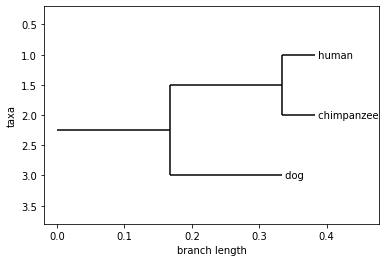

[2]human 
염기 : GCTGTCAAAGCTTAG 
GC 함유량 : 43.120
녹는점 : 4826.000, 
원본 길이 : 1686 (bp), 길이 : 1686 (bp)

[2]dog 
염기 : --------------- 
GC 함유량 : 44.247
녹는점 : 3580.000, 
원본 길이 : 1044 (bp), 길이 : 1686 (bp)

[2]chimpanzee 
염기 : --------------- 
GC 함유량 : 35.172
녹는점 : 3682.000, 
원본 길이 : 1248 (bp), 길이 : 1686 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


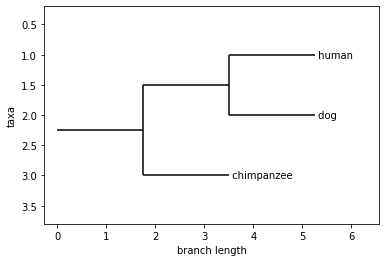

[3]human 
염기 : --------------- 
GC 함유량 : 40.678
녹는점 : 3420.000, 
원본 길이 : 1206 (bp), 길이 : 1239 (bp)

[3]dog 
염기 : --------------- 
GC 함유량 : 57.143
녹는점 : 3504.000, 
원본 길이 : 1044 (bp), 길이 : 1239 (bp)

[3]chimpanzee 
염기 : ACAAGAGATAAATGA 
GC 함유량 : 47.942
녹는점 : 3666.000, 
원본 길이 : 1239 (bp), 길이 : 1239 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


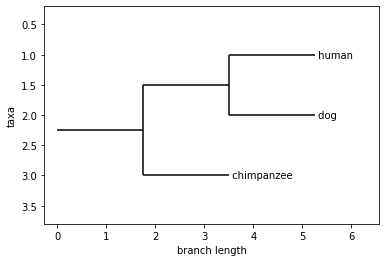

[4]human 
염기 : GCTGTCAAAGCTTAG 
GC 함유량 : 42.728
녹는점 : 4102.000, 
원본 길이 : 1437 (bp), 길이 : 1437 (bp)

[4]dog 
염기 : --------------- 
GC 함유량 : 37.509
녹는점 : 3010.000, 
원본 길이 : 966 (bp), 길이 : 1437 (bp)

[4]chimpanzee 
염기 : --------------- 
GC 함유량 : 44.746
녹는점 : 3302.000, 
원본 길이 : 1008 (bp), 길이 : 1437 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


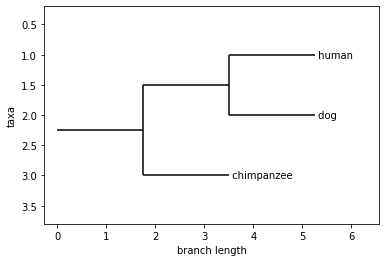

[5]human 
염기 : GCTGTCAAAGCTTAG 
GC 함유량 : 43.120
녹는점 : 4826.000, 
원본 길이 : 1686 (bp), 길이 : 1686 (bp)

[5]dog 
염기 : --------------- 
GC 함유량 : 19.039
녹는점 : 1608.000, 
원본 길이 : 483 (bp), 길이 : 1686 (bp)

[5]chimpanzee 
염기 : --------------- 
GC 함유량 : 36.477
녹는점 : 3150.000, 
원본 길이 : 960 (bp), 길이 : 1686 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


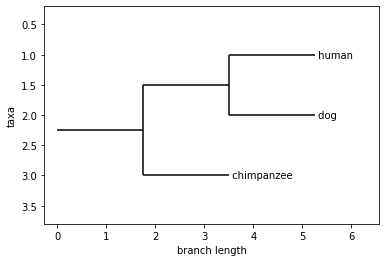

[6]human 
염기 : GCTGTCAAAGCTTAG 
GC 함유량 : 42.884
녹는점 : 4638.000, 
원본 길이 : 1623 (bp), 길이 : 1623 (bp)

[6]dog 
염기 : --------------- 
GC 함유량 : 53.296
녹는점 : 4760.000, 
원본 길이 : 1515 (bp), 길이 : 1623 (bp)

[6]chimpanzee 
염기 : --------------- 
GC 함유량 : 27.603
녹는점 : 3068.000, 
원본 길이 : 1086 (bp), 길이 : 1623 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


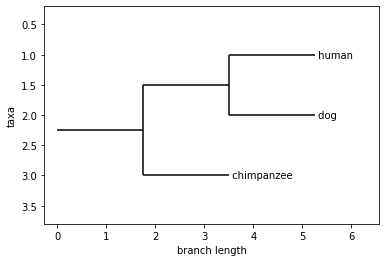

[7]human 
염기 : --------------- 
GC 함유량 : 34.807
녹는점 : 4102.000, 
원본 길이 : 1437 (bp), 길이 : 1764 (bp)

[7]dog 
염기 : --------------- 
GC 함유량 : 47.052
녹는점 : 3850.000, 
원본 길이 : 1095 (bp), 길이 : 1764 (bp)

[7]chimpanzee 
염기 : AAGTCTGCCCACTAA 
GC 함유량 : 63.946
녹는점 : 5784.000, 
원본 길이 : 1764 (bp), 길이 : 1764 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


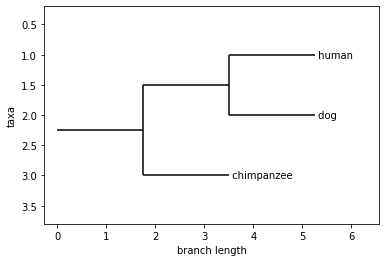

[8]human 
염기 : GCTGTCAAAGCTTAG 
GC 함유량 : 42.884
녹는점 : 4638.000, 
원본 길이 : 1623 (bp), 길이 : 1623 (bp)

[8]dog 
염기 : --------------- 
GC 함유량 : 32.594
녹는점 : 3284.000, 
원본 길이 : 1113 (bp), 길이 : 1623 (bp)

[8]chimpanzee 
염기 : --------------- 
GC 함유량 : 48.860
녹는점 : 4292.000, 
원본 길이 : 1353 (bp), 길이 : 1623 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


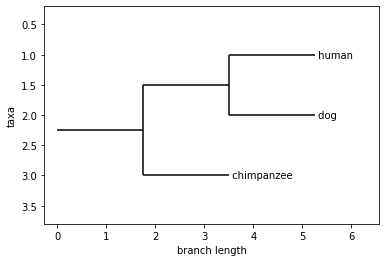

[9]human 
염기 : --------------- 
GC 함유량 : 6.006
녹는점 : 1830.000, 
원본 길이 : 644 (bp), 길이 : 4512 (bp)

[9]dog 
염기 : --------------- 
GC 함유량 : 9.353
녹는점 : 2836.000, 
원본 길이 : 996 (bp), 길이 : 4512 (bp)

[9]chimpanzee 
염기 : GGAGAAAAGGACTAG 
GC 함유량 : 52.992
녹는점 : 13806.000, 
원본 길이 : 4512 (bp), 길이 : 4512 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


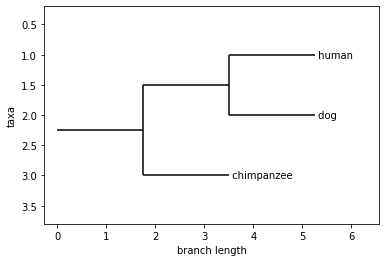

[10]human 
염기 : --------------- 
GC 함유량 : 4.482
녹는점 : 1376.000, 
원본 길이 : 487 (bp), 길이 : 4485 (bp)

[10]dog 
염기 : --------------- 
GC 함유량 : 9.610
녹는점 : 3028.000, 
원본 길이 : 1083 (bp), 길이 : 4485 (bp)

[10]chimpanzee 
염기 : GGAGAAAAGGACTAG 
GC 함유량 : 52.508
녹는점 : 13680.000, 
원본 길이 : 4485 (bp), 길이 : 4485 (bp)

------------------------------------------------------------------------------------------------------------------------
Tree(rooted=False, weight=1.0)
    Clade(branch_length=1.75)
        Clade(branch_length=1.75)
            Clade(branch_length=1.75, name='human')
            Clade(branch_length=1.75, name='dog')
        Clade(branch_length=1.75, name='chimpanzee')


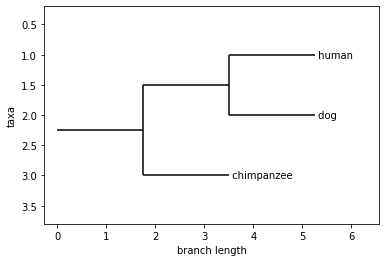

In [36]:
## 주피터 내에서 생성한 Weblogo 파일 보이기
from IPython.display import Image
    
for idx in range(0, 11):
    records = do_muscle(idx)
    phylogenetic_tree(idx)